### Additive Regression (single function)
$$f \sim \cal{GP}(0,k)$$
$$y^{(n)}|f,x^{(n)} = y^{(n)}|\sum_c f(x^{(n)}_c)$$



In [1]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.contrib.opt import ScipyOptimizerInterface as soi
np.random.seed(10)

## Simulating synthetic data

In [2]:
lik = 'Poisson'
lik = 'Gaussian'
assert lik in ['Poisson','Gaussian']

#---------------------------------------------------
# Declaring additive model parameters
N =500
D = 3 # number of covariates 
C = 1 # number of function
R = 1 # number of trials
f_true = lambda x:np.sin(x)**3
#---------------------------------------------------
# Simulating data
np_link,tf_link = np.exp, tf.exp

xmin,xmax=-3,3
X_np = np.random.uniform(xmin,xmax,(N,D)).astype(np.float32)
F_np = np.stack([f_true(X_np[:,d]) for d in range(D)]).T
pred_np = np.sum(F_np,axis=1,keepdims=True)
Y_np = pred_np + np.random.randn(N,R)*.1

if lik == 'Gaussian':
    Y_np = pred_np + np.random.randn(N,R)*.5
elif lik=='Poisson':
    link = np.exp
    rate = np.tile(link(pred_np),[1,R])
    Y_np = np.random.poisson(rate,size=(N,R))


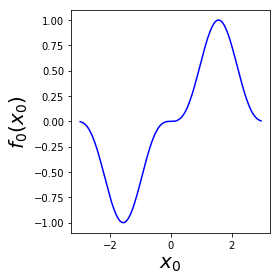

(500, 3) (500, 1)


In [3]:
fig,ax = plt.subplots(1,figsize=(C*4,4))
o = np.argsort(X_np[:,0],0)
ax.plot(X_np[o,0],F_np[o,0],'-',color='b')
ax.set_xlabel('$x_%d$'%0,fontsize=20)
ax.set_ylabel('$f_%d(x_%d)$'%(0,0),fontsize=20)
fig.tight_layout()
plt.show()


print(X_np.shape,Y_np.shape)

## Constructing tensorflow model

In [4]:
import sys
sys.path.append('../SVGPs')
from kernels import RBF
from likelihoods import Gaussian, Poisson, Gaussian_with_link
from settings import np_float_type,int_type
from model import SVGP_shared

#---------------------------------------------------
# Constructing tensorflow model

X = tf.placeholder(tf.float32,[N,D])
Y = tf.placeholder(tf.float32,[N,R])

with tf.variable_scope("kernels") as scope:
    input_dim = 1
    k=  RBF(input_dim,lengthscales=.5*np.ones(input_dim),  variance=1.)

with tf.variable_scope("likelihood") as scope:
    if lik=='Gaussian':
        likelihood = Gaussian(variance=1)
    elif lik == 'Poisson':
        likelihood = Poisson()
    
with tf.variable_scope("ind_points") as scope:
        input_dim = 1
        Z_ = np.random.uniform(xmin,xmax,[10,input_dim]).astype(np_float_type)
        Z =   tf.Variable(Z_,tf.float32,name='Z') 


with tf.variable_scope("model") as scope:
    m= SVGP_shared(X,Y,k,likelihood,Z,q_diag=True)

    
    

In [5]:

sess  = tf.Session()
sess.run(tf.global_variables_initializer()) # reset values to wrong
# declare loss
loss = -m.build_likelihood()
opt_global = tf.train.AdamOptimizer(1e-3).minimize(loss)

init = tf.global_variables_initializer()
sess.run(init) # reset values to wrong
feed_dic = {Y:Y_np, X:X_np}

print(sess.run(m.build_predictor(X),feed_dict=feed_dic)[0].shape)

sess.close()

(500, 1)


## Running inference and learning

In [6]:

#---------------------------------------------------

sess  = tf.Session()
sess.run(tf.global_variables_initializer()) # reset values to wrong
# declare loss
loss = -m.build_likelihood()
opt_global = tf.train.AdamOptimizer(1e-3).minimize(loss)

init = tf.global_variables_initializer()
sess.run(init) # reset values to wrong
feed_dic = {Y:Y_np, X:X_np}

#---------------------------------------------------


print('Running Optimization...')
nit = 8000
loss_array = np.zeros((nit,))

for it in tqdm(range( nit)):
    sess.run(opt_global,feed_dict=feed_dic)
    loss_array[it]= float(sess.run(loss, feed_dic))


# declare which optimization to perform


p_mean,p_var = sess.run(m.build_predictor(X),  feed_dic)
F_mean,F_var = sess.run(m.build_predict(X),  feed_dic)
Z = sess.run(m.Z,  feed_dic)

sess.close()

print('Done')


  0%|          | 7/8000 [00:00<01:57, 67.97it/s]

Running Optimization...


100%|██████████| 8000/8000 [00:45<00:00, 174.12it/s]


Done


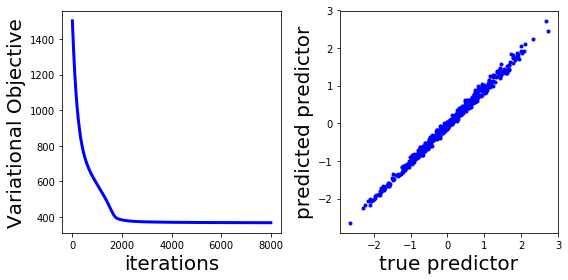

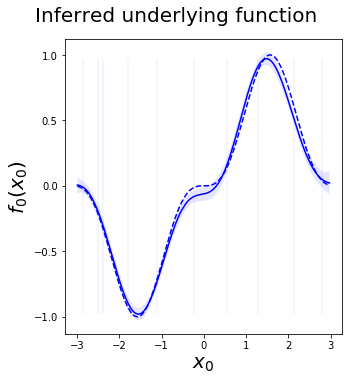

In [10]:
fig,axarr = plt.subplots(1,2,figsize=(8,4))
ax=axarr[0]
ax.plot(loss_array[:it], linewidth=3, color='blue')
ax.set_xlabel('iterations',fontsize=20)
ax.set_ylabel('Variational Objective',fontsize=20)
ax=axarr[1]
ax.plot(pred_np, p_mean,'.', color='blue')
ax.set_xlabel('true predictor',fontsize=20)
ax.set_ylabel('predicted predictor',fontsize=20)
fig.tight_layout()
plt.show()
plt.close()


fig,ax = plt.subplots(1,figsize=(C*5,5))
o = np.argsort(X_np[:,0],0)
f,s =  F_mean[:,0],np.sqrt(F_var[:,0])
ax.vlines(Z,ymin=f.min(),ymax=f.max(),alpha=.05,color='b')
ax.plot(X_np[o,0],f[o],color='b')
ax.fill_between(X_np[o,0].flatten(),
                   (f-s)[o].flatten(),
                   y2=(f+s)[o].flatten(),
                   alpha=.1,facecolor='b')
ax.plot(X_np[o,0],F_np[o,0],'--',color='b')
ax.set_xlabel('$x_%d$'%0,fontsize=20)
ax.set_ylabel('$f_%d(x_%d)$'%(0,0),fontsize=20)
plt.suptitle('Inferred underlying function',y=1.05,fontsize=20) 
fig.tight_layout()

plt.show()